**Блокнот по проведению word-level probing экспериментов**

In [ ]:
!pip --quiet install transformers sentencepiece conllu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 16.5 MB/s eta 0:00:00


In [ ]:
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_French-GSD/master/fr_gsd-ud-test.conllu -O french_gender.conllu

--2023-02-21 10:04:49--  https://raw.githubusercontent.com/UniversalDependencies/UD_French-GSD/master/fr_gsd-ud-test.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 645402 (630K) [text/plain]
Saving to: ‘french_gender.conllu’

french_gender.conll 100%[===================>] 630.28K  --.-KB/s    in 0.004s  

2023-02-21 10:04:49 (145 MB/s) - ‘french_gender.conllu’ saved [645402/645402]



In [ ]:
import torch
import pandas as pd
import numpy as np
from transformers import CamembertModel, CamembertTokenizer, BertModel, BertTokenizer

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Loading the model

In [ ]:
# try:
#     del tokenizer
#     del model
# except:
#     pass

def get_pretrained(model_name, model_class=CamembertModel, tokenizer_class=CamembertTokenizer, device=DEVICE):
    tokenizer = tokenizer_class.from_pretrained(model_name)
    model = model_class.from_pretrained(model_name, output_hidden_states=True)
    model = model.to(device)
    return model, tokenizer

model, tokenizer = get_pretrained('camembert-base')

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def get_sentence_embs(sentence, model=model, tokenizer=tokenizer, device=DEVICE):
    """
    Возвращает эмбеддинги предложений по слоям. Эмбеддинг предложения == усреднённые эмбеддинги токенов
    """
    with torch.no_grad():
        inputs = tokenizer(sentence, return_tensors='pt').to(device)
        outputs = model(**inputs)
        return [layer_emb.mean(axis=1).squeeze().cpu().numpy() for layer_emb in outputs.hidden_states][1:]

len(get_sentence_embs('Vous m\'accusez de "subjectivisme".'))  # 12 layers in bert base

12

In [ ]:
def get_word_features(toks, token_features):
    """
    Принимает в качестве аргументов токенизированное предложение и выход модели на нём. Собирает из выхода по токенам выход по словам.
    """
    token_features = token_features[1:-1] # drop CLS and SEP tokens
    word_features = []
    for i in range(len(token_features)):
        if not toks[i].startswith(chr(9601)): # It's the continuation of the last word
            word_features[-1] += token_features[i]
        else: # A new word has started
            word_features.append(token_features[i])
    return torch.stack(word_features, dim=0)


def get_word_embs(sentence, model=model, tokenizer=tokenizer, device=DEVICE):
    """
    Возвращает эмбеддинги слов по слоям. Эмбеддинг слова == усреднённые эмбеддинги токенов, на которые оно разбито (обычно 1 токен).
    """
    with torch.no_grad():
        inputs = tokenizer(sentence, return_tensors='pt').to(device)
        # print(tokenizer.convert_ids_to_tokens(tokenizer(sentence)["input_ids"]))
        outputs = model(**inputs)
        hidden_states = torch.stack(outputs.hidden_states, dim=0) # Convert tuple of layers to torch tensor
        hidden_states = torch.squeeze(hidden_states, dim=1) # Drop batch dimension which is equal to 1
        # hidden_states = hidden_states[1:] # Drop the input layer

        result = []
        toks = tokenizer.tokenize(sentence)
        for layer in hidden_states:
            result.append(get_word_features(toks, layer))
        
        return torch.permute(torch.stack(result, dim=0), [1,0,2])


text = "J'aime camembert!" #The word camembert is split into multiple tokens => this sentence is good for testing
res = get_word_embs(text)
res.size()

torch.Size([2, 13, 768])

In [ ]:
def join_parsings(bert_tokenization, ud_tokenization): # accepts two tokenizations and returns list of features for bert tokenization
    bert_words = []
    for item in bert_tokenization:
        if not item.startswith(chr(9601)): # It's the continuation of the last word
            bert_words[-1] += item
        else: # A new word has started
            bert_words.append(item[1:])
    ud_features = [[]]
    last_word, last_symbol = 0, 0
    skip_ids = -1
    for item in ud_tokenization:
        if type(item["id"]) is int and item["id"] <= skip_ids:
            continue
        if bert_words[last_word][last_symbol:].startswith(item["form"]):
            last_symbol += len(item["form"])
            ud_features[-1].append(item)

            if type(item["id"]) is not int:
                skip_ids = item["id"][2]

            if last_symbol == len(bert_words[last_word]): # We've reached the end in the current word
                if len(ud_features[-1]) == 0:
                    print("this is weird...")
                last_word, last_symbol = last_word + 1, 0 # Switch to the next word in bert tokenization
                ud_features.append([])
        else:
            print("There has been a problem merging", bert_tokenization, "with", ud_tokenization)
            return
    ud_features.pop() # Remove the last emtpy features list
    return bert_words, ud_features

In [ ]:
test_data = pd.DataFrame.from_dict({"text": ["This is a great time for it", "This was a great time for it", "I ran home", "I run home", "I want to go", "I wanted to go", "I am cool", "I was cool"], \
                          "word_index": [1, 1, 1, 1, 1, 1, 1, 1], \
                          "target": [0, 1, 1, 0, 0, 1, 0, 1]}) # Это я типа время предсказываю по глаголу

for i in test_data.index:
    # test_data.loc[i, "feature"]
    thing = np.array(get_word_embs(test_data.loc[i, "text"])[test_data.loc[i, "word_index"]][5].cpu())
    test_data.loc[i, ["feat_" + str(x) for x in range(768)]] = thing

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(test_data.drop(columns=["target", "text", "word_index"]), test_data["target"], train_size=0.5)

logreg = LogisticRegression()
logreg.fit(X_tr, y_tr)
accuracy_score(y_te, logreg.predict(X_te))

['<s>', '▁This', '▁is', '▁a', '▁great', '▁time', '▁for', '▁it', '</s>']
['<s>', '▁This', '▁was', '▁a', '▁great', '▁time', '▁for', '▁it', '</s>']
['<s>', '▁I', '▁', 'ran', '▁home', '</s>']
['<s>', '▁I', '▁run', '▁home', '</s>']
['<s>', '▁I', '▁w', 'ant', '▁to', '▁go', '</s>']
['<s>', '▁I', '▁w', 'ant', 'ed', '▁to', '▁go', '</s>']
['<s>', '▁I', '▁am', '▁cool', '</s>']
['<s>', '▁I', '▁was', '▁cool', '</s>']


0.25

### Loading datasets

In [ ]:
import conllu

In [ ]:
with open("french_gender.conllu", 'r') as f:
    data = conllu.parse(f.read())

In [ ]:
data[0].metadata["text"], len(data[0]), data[0][27]

("Je sens qu'entre ça et les films de médecins et scientifiques fous que nous avons déjà vus, nous pourrions emprunter un autre chemin pour l'origine.",
 29,
 {'id': 28,
  'form': 'origine',
  'lemma': 'origine',
  'upos': 'NOUN',
  'xpos': None,
  'feats': {'Gender': 'Fem', 'Number': 'Sing'},
  'head': 22,
  'deprel': 'obl:mod',
  'deps': None,
  'misc': {'SpaceAfter': 'No'}})

In [ ]:
samples = [[], [], []] # Gather data here, first list contains texts, second contains word indices, third contains labels

cnt = 0
for sentence in data:
    bert_tokens = tokenizer.tokenize(sentence.metadata["text"])
    result = join_parsings(bert_tokens, sentence)
    if result is None:
        # print(sentence)
        # for item in sentence:
        #     print(item["id"], item["form"])
        #     # print(inspect.getmembers(item))
        cnt += 1
        continue
    tokens, feats = result
    for ind in range(len(feats)):
        if len(feats[ind]) > 1: # This is a multiword token, let's skip it for now
            continue
        if feats[ind][0]["upos"] == "NOUN" and feats[ind][0]["feats"] is not None and feats[ind][0]["feats"].get("Gender") is not None:
            samples[0].append(sentence.metadata["text"])
            samples[1].append(ind)
            samples[2].append(int(feats[ind][0]["feats"]["Gender"] == "Fem"))

print(cnt, "out of", len(data), "failed")
french_gender = pd.DataFrame.from_dict({"text": samples[0], "word_ind": samples[1], "target": samples[2]})

There has been a problem merging ['▁Envoyez', '▁le', '▁mot', '▁"', 'DA', 'RG', 'AUD', '"', '▁suivi', '▁de', '▁vos', '▁coordonnées', '▁au', '▁6', '▁20', '▁30', '▁(0', '.', '35', '▁c', 'ts', '▁d', "'", 'euro', '▁+', '▁coût', '▁du', '▁SMS', ')', '▁et', '▁répond', 'ez', '▁au', '▁qui', 'z', '.'] with TokenList<Envoyez, le, mot, ", DARGAUD, ", suivi, de, vos, coordonnées, au, à, le, 6 20 30, (, 0.35, cts, d', euro, +, coût, du, de, le, SMS, ), et, répondez, au, à, le, quiz, ., metadata={sent_id: "fr-ud-test_00188", text: "Envoyez le mot "DARGAUD" suivi de vos coordonnées au 6 20 30 (0.35 cts d'euro + coût du SMS) et répondez au quiz."}>
There has been a problem merging ['▁Les', '▁papillons', '▁sont', '▁visibles', '▁entre', '▁mai', '▁et', '▁juin', '▁dans', '▁les', '▁zones', '▁de', '▁faibles', '▁altitude', 's', '▁tandis', '▁qu', "'", 'au', '▁dessus', '▁de', '▁1', '▁000', '▁mètres', ',', '▁les', '▁papillons', '▁sont', '▁visibles', '▁vers', '▁le', '▁début', '▁juillet', '.'] with TokenList<Les, p

In [ ]:
french_gender

,text,word_ind,target
0,Je sens qu'entre ça et les films de médecins e...,6,0
1,Je sens qu'entre ça et les films de médecins e...,8,0
2,Je sens qu'entre ça et les films de médecins e...,10,0
3,Je sens qu'entre ça et les films de médecins e...,22,0
4,On pourra toujours parler à propos d'Averroès ...,5,0
...,...,...,...
1310,Une réunion du conseil national du syndicat de...,19,0
1311,Une réunion du conseil national du syndicat de...,21,0
1312,Une réunion du conseil national du syndicat de...,27,1
1313,"Anne-Sophie Mathis, née le 13 juin 1977 à Nanc...",5,0


In [ ]:
len(french_gender["text"].unique()), french_gender["target"].mean()

(377, 0.40760456273764256)

### Learning the probing classifier

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from time import time


# stacked_train_X = np.stack(train_X)
# stacked_val_X = np.stack(val_X)
# stacked_test_X = np.stack(test_X)


def logreg(X_train, y_train, X_test, y_test):
    le = LogisticRegression(tol=0.01, max_iter=1000)
    le = le.fit(X_train, y_train)
    y_pred = le.predict(X_test)
    return f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)


def train(
    layer,
    classifier_func,
    stacked_train_X,
    train_y,
    stacked_test_X,
    test_y
):
    """Обучает пробинг-классификатор (функция classifier_func) для слоя layer"""
    X = stacked_train_X[:, layer, :]
    y = train_y.to_numpy()
    f1, acc = classifier_func(X, y, stacked_test_X[:, layer, :], test_y.to_numpy())
    return f1, acc

## Эксперименты

In [ ]:
all_embs = []
for row in french_gender.index:
    embs = np.array(get_word_embs(french_gender.loc[row, "text"])[french_gender.loc[row, "word_ind"]][0].cpu())
    all_embs.append(embs)


In [ ]:
X = np.stack(all_embs)
X.shape

(1315, 768)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
blahblah = np.array(french_gender["target"])
np.random.shuffle(blahblah)

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, blahblah, train_size=0.7)
logreg(X_tr, y_tr, X_te, y_te)

(0.4050632911392405, 0.5240506329113924)

In [ ]:
def experiment(classifier_func, model, tokenizer, device, dataset):
    print("Getting embeddings...")
    t1 = time()
    

In [ ]:
experiment(1, model, tokenizer, DEVICE, french_gender)

Getting embeddings...
0
Je sens qu'entre ça et les films de médecins et scientifiques fous que nous avons déjà vus, nous pourrions emprunter un autre chemin pour l'origine. 6 torch.Size([25, 12, 768])
1
Et pourtant, lors de sa première visite en Afrique subsaharienne, l'été 2007, il montre les dents dans un discours humiliant pour les Africains, prononcé à l'Université Cheikh Anta Diop de Dakar. 7 torch.Size([31, 12, 768])
2
Ils ne citent pas son nom, parce que depuis les institutions on n'attaque pas un membre de la famille royale, mais c'est à lui qu'ils s'en prennent. 5 torch.Size([27, 12, 768])
3
Il y en a qui croient toujours qu'ils peuvent jouir de la vie en toute tranquillité de conscience et commettre telle ou telle indélicatesse, telle ou telle grossièreté, en toute sécurité, parce que leur coeur serait comme les montres : 100% Waterproof. 12 torch.Size([42, 12, 768])
4
Royale donc, cette voie de communication est aussi vouée à être préservée, développée et modernisée. 4 torch

IndexError: ignored

In [ ]:
# Logistic regression experiment


def experiment(
    classifier_func,
    model_name=None,
    model=None,
    tokenizer=None,
    model_class=BertModel,
    tokenizer_class=BertTokenizer,
    dataset=None,
    dataset_X=None,
    dataset_y=None,
    sentence_embeddings_func=get_sentence_embs,
    layers_cnt=12
):
    """Проводит один эксперимент с заданными параметрами"""
    print('getting model...')
    if model is None:
        model, tokenizer = get_pretrained(model_name, model_class, tokenizer_class)
    
    print('getting embeddings...')
    t1 = time()
    if dataset_X is None:
        dataset_X = dataset.text.apply(sentence_embeddings_func, model=model, tokenizer=tokenizer, device=DEVICE)
        dataset_y = dataset.label
    print(f"Time spent on applying NN to data is {time() - t1}")

    print('splitting and stacking...')
    train_X, train_y = get_subset('tr', dataset_X=dataset_X, dataset_y=dataset_y, subset_col=dataset.subset)
    # val_X, val_y = get_subset('va', dataset_X=dataset_X, dataset_y=dataset_y, subset_col=dataset.subset)
    test_X, test_y = get_subset('te', dataset_X=dataset_X, dataset_y=dataset_y, subset_col=dataset.subset)

    stacked_train_X = np.stack(train_X)
    # stacked_val_X = np.stack(val_X)
    stacked_test_X = np.stack(test_X)

    print('probing...')
    layers = list(range(layers_cnt))
    f1s = []
    accs = []
    exec_times = []
    for layer in layers:
        start_time = time()
        f1, acc = train(layer, logreg, stacked_train_X, train_y, stacked_test_X, test_y)
        exec_time = time() - start_time
        print(f'layer {layer + 1}: f1 score {f1:.4f}, accuracy {acc:.4f}, time {exec_time:.4f}')
        f1s.append(f1)
        accs.append(acc)
        exec_times.append(exec_time)
    return f1s, accs, exec_times


def show_exp(f1s, accs, layers_cnt=12):
    """Рисует графики скоров"""
    fig = plt.figure()
    layers = range(layers_cnt)
    plt.plot(layers, f1s, label='f1')
    plt.plot(layers, accs, label='accuracy')
    plt.title('Logreg probing quality wrt BERT layer')
    plt.xlabel('BERT layer')
    plt.ylabel('Metric score')
    plt.legend()
    plt.show()

#### logreg для bert-base-uncased

In [ ]:
f1s, accs, times = experiment(classifier_func=logreg, model_name='bert-base-uncased', dataset=dataset, sentence_embeddings_func=get_sentence_embs)

getting model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


getting embeddings...
Time spent on applying NN to data is 570.1355421543121
splitting and stacking...
probing...
layer 1: f1 score 0.3671, accuracy 0.9513, time 25.4691
layer 2: f1 score 0.3096, accuracy 0.9507, time 29.0840
layer 3: f1 score 0.3088, accuracy 0.9489, time 31.7138
layer 4: f1 score 0.3372, accuracy 0.9480, time 30.2688
layer 5: f1 score 0.3458, accuracy 0.9493, time 36.2206
layer 6: f1 score 0.3224, accuracy 0.9475, time 18.6234
layer 7: f1 score 0.3246, accuracy 0.9488, time 36.4438
layer 8: f1 score 0.3262, accuracy 0.9484, time 19.3078
layer 9: f1 score 0.3310, accuracy 0.9473, time 27.7272
layer 10: f1 score 0.3084, accuracy 0.9464, time 29.0826
layer 11: f1 score 0.3255, accuracy 0.9482, time 30.7768
layer 12: f1 score 0.3005, accuracy 0.9460, time 23.9124


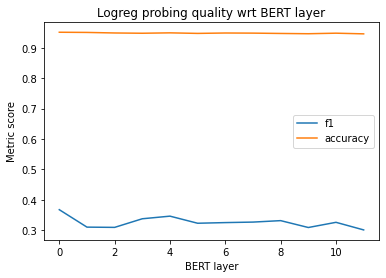

In [ ]:
show_exp(f1s, accs)

Лучший F1 на первом слое ($0.3671$), затем --- на пятом ($0.3458$). После пятого есть нестабильное снижение до $0.3$. В целом скор низковат, м.б. нужно улучшать классификатор

#### logreg для distilbert

In [ ]:
f1s, accs = experiment(
    classifier_func=logreg,
    model_name='distilbert-base-uncased',
    model_class=DistilBertModel,
    tokenizer_class=DistilBertTokenizer,
    dataset=dataset,
    sentence_embeddings_func=get_sentence_embs
)

getting model...


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


getting embeddings...
splitting and stacking...
probing...
layer 1: f1 score 0.3546, accuracy 0.9506
layer 2: f1 score 0.3108, accuracy 0.9502
layer 3: f1 score 0.3066, accuracy 0.9484
layer 4: f1 score 0.3435, accuracy 0.9495
layer 5: f1 score 0.3246, accuracy 0.9488
layer 6: f1 score 0.3107, accuracy 0.9486


IndexError: ignored

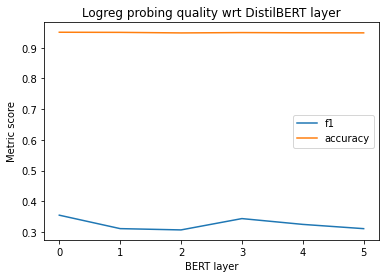

In [ ]:
show_exp(f1s, accs, 6)

Первый слой хуже, чем у bert. Четвёртый слой --- экстремум (похож на бертовский), после чего похожий спад.

#### logreg на флотах до двух знаков

In [ ]:
def get_sentence_rounded_embs(sentence, model=model, tokenizer=tokenizer, device=DEVICE, precision=None):
    """
    Возвращает эмбеддинги предложений по слоям, обрезает до precision знаков после точки.
    Эмбеддинг предложения == усреднённые эмбеддинги токенов.
    """
    if precision is None:
      precision = 100
    with torch.no_grad():
        inputs = tokenizer(sentence, return_tensors='pt').to(device)
        outputs = model(**inputs)
        return [np.around(layer_emb.mean(axis=1).squeeze().cpu().numpy(), decimals=precision) for layer_emb in outputs.hidden_states][1:]

get_sentence_rounded_embs('Hello darkness my old friend', precision=2)[1][:10]

array([ 0.33,  0.43,  0.34, -0.32,  0.14, -0.04,  0.04, -0.11, -0.1 ,
       -0.37], dtype=float32)

In [ ]:
def get_sentence_rounded_to_2_embs(sentence, **kwargs):
    return get_sentence_rounded_embs(sentence, precision=2, **kwargs)

get_sentence_rounded_to_2_embs('Hello darkness my old friend')[1][:10]

array([ 0.33,  0.43,  0.34, -0.32,  0.14, -0.04,  0.04, -0.11, -0.1 ,
       -0.37], dtype=float32)

In [ ]:
# эксперимент с обрезанием до 2 знаков

f1s, accs, times = experiment(classifier_func=logreg, model_name='bert-base-uncased', dataset=dataset, sentence_embeddings_func=get_sentence_rounded_to_2_embs)

getting model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


getting embeddings...
splitting and stacking...
probing...
layer 1: f1 score 0.3571, accuracy 0.9511, time 36.7255
layer 2: f1 score 0.3096, accuracy 0.9507, time 46.5185
layer 3: f1 score 0.3122, accuracy 0.9489, time 37.9118
layer 4: f1 score 0.3372, accuracy 0.9480, time 42.2503
layer 5: f1 score 0.3570, accuracy 0.9491, time 37.0289
layer 6: f1 score 0.3279, accuracy 0.9473, time 16.0161
layer 7: f1 score 0.3278, accuracy 0.9488, time 33.8799
layer 8: f1 score 0.3262, accuracy 0.9484, time 25.7327
layer 9: f1 score 0.3310, accuracy 0.9473, time 26.9869
layer 10: f1 score 0.3052, accuracy 0.9464, time 30.8449
layer 11: f1 score 0.3255, accuracy 0.9482, time 28.0620
layer 12: f1 score 0.2918, accuracy 0.9455, time 20.4978


Первый слой чуть хуже берта, локальный оптимум даже чуть лучше (слой 5), последний слой меньше $0.3$.

#### logreg на флотах float16

In [ ]:
def get_sentence_float16(sentence, **kwargs):
    return [vec.astype(np.float16) for vec in get_sentence_embs(sentence, **kwargs)]

get_sentence_float16('Hello darkness my old friend')[1][:10]

array([ 0.3298 ,  0.4316 ,  0.3357 , -0.319  ,  0.1411 , -0.0444 ,
        0.03528, -0.1063 , -0.0996 , -0.3687 ], dtype=float16)

In [ ]:
f1s, accs, times = experiment(
    classifier_func=logreg, model_name='bert-base-uncased', dataset=dataset, sentence_embeddings_func=get_sentence_float16
)

getting model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


getting embeddings...
splitting and stacking...
probing...
layer 1: f1 score 0.3671, accuracy 0.9513, time 26.5516
layer 2: f1 score 0.3096, accuracy 0.9507, time 32.4015
layer 3: f1 score 0.3088, accuracy 0.9489, time 33.9357
layer 4: f1 score 0.3372, accuracy 0.9480, time 30.2062
layer 5: f1 score 0.3458, accuracy 0.9493, time 41.2677
layer 6: f1 score 0.3224, accuracy 0.9475, time 22.7097
layer 7: f1 score 0.3246, accuracy 0.9488, time 34.3441
layer 8: f1 score 0.3262, accuracy 0.9484, time 17.0350
layer 9: f1 score 0.3310, accuracy 0.9473, time 26.9343
layer 10: f1 score 0.3084, accuracy 0.9464, time 29.7174
layer 11: f1 score 0.3255, accuracy 0.9482, time 30.9297
layer 12: f1 score 0.3005, accuracy 0.9460, time 20.6070


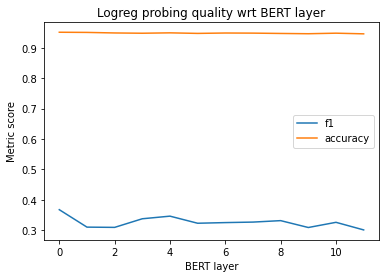

In [ ]:
show_exp(f1s, accs)

В среднем слой отрабатывал на $2$ секунды быстрее, чем в оригинальном эксперименте для `float32`, без потери качества